In [1]:
import numpy as np
import sympy as sp
from scipy import optimize 

import matplotlib.pyplot as plt 

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

<br>
<br>

## Answer to question 1
> **Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [4]:
from examproject import problem_one

We begin by setting up the following two function. `ex_post_v2` takes the level of human capital in period 2 $h_2$ for given (ex post the shock to human capital accumulation) and takes the labor supply decision $l_1$ as a variable. It then simply calculates the total utility of the agent with human capital $h_2$ who chooses $l_2\in {0,1}$.

Note that all of the functions that are not defined in the notebook itself are located in /examproject/problem_one.py. 

`period_2_solver` evaluates the target both for a labor decision of $l_2=1$ and $l_2=0$, and returns a boolean which is 1 if the utility of working exceeds the utility of not working.

Finally we run this solver across all elements of `h_vec` which associates with each level of human capital a labor supply desicion which is shown in the figure. 

In [5]:
def ex_post_v2(l2: bool, h2: float):
    ''' Calculate consumption from h_2 and state
        and calculate utility from this.
        
    Args: 
        l2: labor supply desicion
        h2: human capital level
        
    Returns:
        Number
    '''
    c2 = problem_one.consumption(h2, l2)        
    utility = problem_one.total_utility(c2, l2)
    
    return utility


def period_2_solver(h2: float):
    ''' Solve the period 2 problem ex post 
    
    Args:
        h2: human capital level
        
    Returns:
        bool, float
    '''
    work = ex_post_v2(1, h2)
    nowork = ex_post_v2(0, h2)
    
    return work >= nowork, np.max([work, nowork])

No handles with labels found to put in legend.


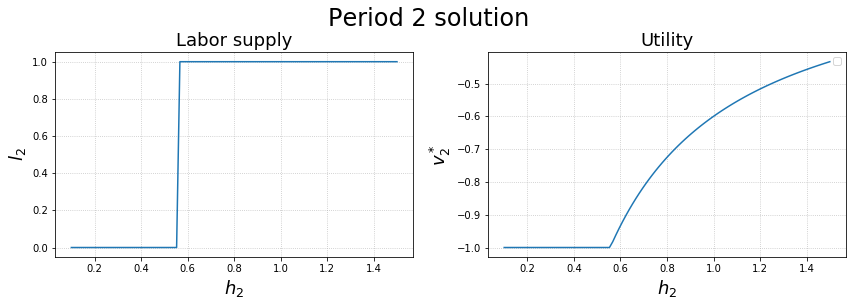

In [6]:
p2_sol = [period_2_solver(h) for h in h_vec]

problem_one.plot_period_2_solution(h_vec, p2_sol)
plt.show()

In [7]:
# This is just the smallest number in h_vec that produces 
# a labor supply of 1
h_vec[np.array([s[0] for s in p2_sol]) == 1].min()

0.5666666666666667

Thus we see that labor is supplied in period 2 with a human capital level above 0.56.

<br>
<br>

## Answer to question 2

> **Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 


Next we solve the model in period 1, for this we need an ex-ante version of $v_2$ that is dependent on the realization of $h_2$, using this we calculate the expected utility of period 2 simply be resolving the problem $ndraws$ times with stochastic human capital. 

with this in place we can solve for period 1 simply by calculating $v_1$ for both $l_1=0,1$ and choosing the option that gives the highest utility. 

In [8]:
_RNG = np.random.RandomState(seed = 0)

In [9]:
def ex_ante_v2(h1: float, l1: bool, rng: np.random.RandomState) -> tuple:
    ''' Ex ante version of v2
    
    Args:
        h1: human capital in period 1
        l1: labor decision in period 1
        rng: random number generator
        
    Returns 
        bool, float
    '''
    h2 = problem_one.human_capital_accumulation(h1, l1, rng)    
    choice, utility = period_2_solver(h2)
    
    return choice, utility


def expected_v2(h1: float, l1: float, rng: np.random.RandomState, ndraws: int) -> float:
    ''' The expected value of v2
    
    Args:
        h1: human capital in period 1
        l1: labor decision in period 1
        rng: random number generator
        ndraws: the number of draws for calculating the expectation
    
    '''
    draws = [ex_ante_v2(h1, l1, rng) for _ in range(ndraws)]
    return beta*np.mean(draws)


def v1(h1: float, l1: float, rng: np.random.RandomState, ndraws: int) -> float:
    ''' v1
    
    Args: 
        h1: HC in period 1
        l1: labor decision in period 1
        rng: random number generator
        ndraws: number of draws
    '''
    c1 = problem_one.consumption(h1, l1)    
    ev2 = expected_v2(h1, l1, rng, ndraws)
    u1 = problem_one.total_utility(c1, l1) + ev2
    return u1


def period_1_solver(h1: float, rng: np.random.RandomState, ndraws: int):
    ''' Solve the period 1 problem
    
    Args:
        h1: HC in period 1 
        rng: random number generator
        ndraws: number of draws
    '''
    work = v1(h1, 1, rng, ndraws)
    nowork = v1(h1, 0, rng, ndraws)
    
    return work >= nowork, np.max([work, nowork])

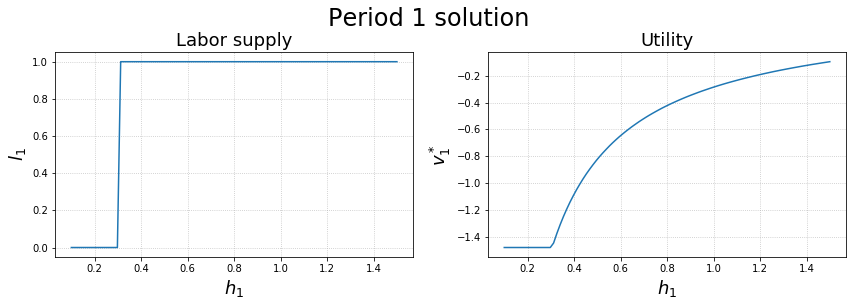

In [10]:
p1_sol = [period_1_solver(h, _RNG, 1000) for h in h_vec]
problem_one.plot_period_1_solution(h_vec, p1_sol)
plt.show()

Thus the level of human capital required for working is lower in period 1 than in period 2, this is because working in period 1 earns additional human capital which makes working in period 2 worth more. 

<br>
<br>

## Answer to question 3
> **Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

We interpret the question to ask; "is it possible that she will work in period 1, even though $w h_1 < b$". Yes this is possible, exactly because working in period 1 gives additional human capital in period 2, so if $h_1$ is sufficiently high (but lower than to make $wh_1 \geq b$) the expected benefit on period 2 utility outweighs apparent negative utility of working in period 1. 

The figure below shows the range of human capital levels in period 1 for which it is worthwile to work even though $wh_1 - b < 0$.

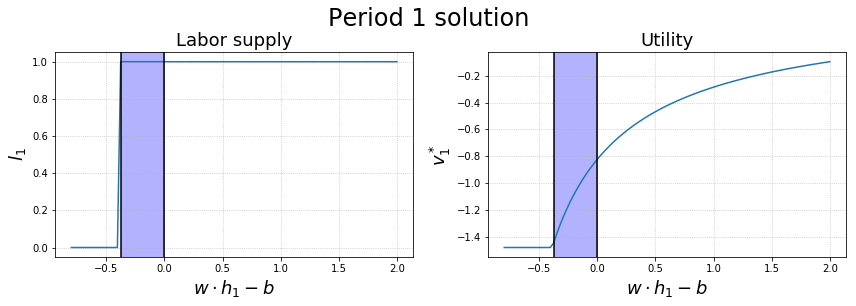

In [11]:
lowest_work_sol = h_vec[np.array([s[0] for s in p1_sol]) == 1].min() 

problem_one.plot_period_1_solution_with_vbands(h_vec, p1_sol, lowest_work_sol)
plt.show()

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [12]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [13]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [14]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

<br>
<br>

## Answer to question 1
> **Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.



In [15]:
from examproject import problem_two
sp.init_printing(use_unicode=True)

In [16]:
y_t = sp.symbols('y_t')
y_tm1 = sp.symbols('y_{t-1}')
r_t = sp.symbols('r_t')
v_t = sp.symbols('v_t')
i_t = sp.symbols('i_t')
s_t = sp.symbols('s_t')
s_tm1 = sp.symbols('s_{t-1}')

pi_tp1_e = sp.symbols('\pi_{t+1}^e')
pi_t_e = sp.symbols('pi_t^e')
pi_t = sp.symbols('\pi_t')

pi_tm1 = sp.symbols('\pi_{t-1}')

alpha = sp.symbols('alpha')
gamma = sp.symbols('gamma')
phi = sp.symbols('phi')
h = sp.symbols('h')
b = sp.symbols('b')

y_t, r_t, v_t, i_t, pi_tp1_e, pi_t, alpha, h, b, s_t, gamma, pi_t_e, pi_tm1, y_tm1, s_tm1

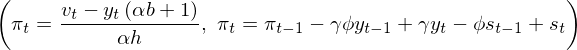

In [17]:
AD = sp.Eq(pi_t, (1/(h*alpha)) * (v_t - (1 + b*alpha)*y_t) )
SRAS = sp.Eq(pi_t, pi_tm1 + gamma*y_t - phi*gamma*y_tm1 + s_t - phi*s_tm1)

AD, SRAS

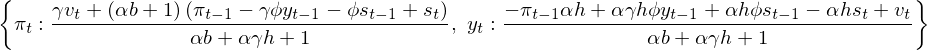

In [18]:
SRAS_AD_solution = sp.solve((AD,SRAS), (y_t, pi_t))
SRAS_AD_solution

Thus we find that $\pi_t$ is 

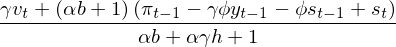

In [19]:
SRAS_AD_solution[pi_t]

And $y_t$ is 

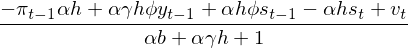

In [20]:
SRAS_AD_solution[y_t]

<br>
<br>

## Answer to question 2

> **Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

We begin by lambdifying the AD and SRAS curves, as well as the specifications of the equilibrium derived above. The equilibrium values are joined in a single function `ASAD_solution` that returns the $y^*,\pi^*$ pairs.

In [21]:
sp.init_printing(pretty_print=False)

_AD_curve = sp.lambdify((y_t, v_t, alpha, b, h), AD.rhs)
def AD_curve(y_t, v_t,
             alpha = par['alpha'], 
             b = par['b'] , h = par['h']
            ):
    return _AD_curve(y_t, v_t, alpha, b, h)


_SRAS_curve = sp.lambdify((y_t, pi_tm1, gamma, phi, y_tm1, s_tm1, s_t) , SRAS.rhs)
def SRAS_curve(y_t, pi_tm1, y_tm1, s_tm1, s_t,
               gamma = par['gamma'], phi = par['phi']
              ):
    return _SRAS_curve(y_t, pi_tm1, gamma, phi, y_tm1, s_tm1, s_t)


_x_sol = sp.lambdify( (pi_tm1, alpha, h, gamma, phi, y_tm1, s_tm1, s_t, v_t, b) ,SRAS_AD_solution[y_t])
def solution_x_component(v_t, pi_tm1, y_tm1, s_tm1,
                         s_t, alpha = par['alpha'], 
                         h = par['h'] , gamma = par['gamma'], 
                         phi = par['phi'], b = par['b']
                        ):
    return _x_sol(pi_tm1, alpha, h, gamma, phi, y_tm1, s_tm1, s_t, v_t, b)


_y_sol = sp.lambdify( (gamma, v_t, alpha, b, pi_tm1, phi, y_tm1, s_tm1, s_t, h) ,SRAS_AD_solution[pi_t])
def solution_y_component(v_t, pi_tm1, y_tm1, s_tm1, s_t,
                         phi = par['phi'], h = par['h'],
                         alpha = par['alpha'] , b = par['b'],
                         gamma = par['gamma']
                        ):
    return _y_sol(gamma, v_t, alpha, b, pi_tm1, phi, y_tm1, s_tm1, s_t, h)




def ASAD_solution(v_t, pi_tm1, y_tm1, s_tm1, s_t,
                  phi = par['phi'], h = par['h'],
                  alpha = par['alpha'] , b = par['b'],
                  gamma = par['gamma']
                ):
    x = solution_x_component(v_t, pi_tm1, y_tm1, s_tm1,
                         s_t, alpha, h, gamma, phi, b)
    
    y = solution_y_component(v_t, pi_tm1, y_tm1, s_tm1, s_t,
                         phi, h, alpha, b, gamma)
    return x,y 

Then all that is left is to visualize the effect of a shift in $v_1$. Note that the SRAS curve does not depend on $v_1$ and is thus stationary under the change.

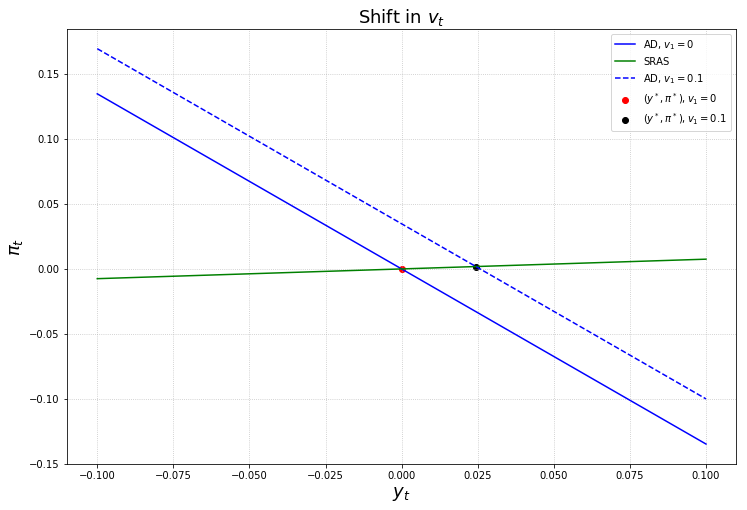

In [22]:
def ShiftInV1(v_1: float):
    ''' PLot a shift in v_1
    '''
    yspace = np.linspace(-0.1,0.1)
    
    x0, y0 = ASAD_solution(0,0,0,0,0)
    x1, y1 = ASAD_solution(v_1,0,0,0,0)
    
    fig, ax = plt.subplots(figsize = (12,8))
    
    ax.plot(yspace, [AD_curve(y, 0) for y in yspace], color = 'blue', label = 'AD, $v_1=0$')
    ax.plot(yspace, [SRAS_curve(y, 0, 0, 0, 0) for y in yspace], color = 'green', label = 'SRAS')
    ax.scatter([x0], [y0], color = 'red', label = '$(y^*, \pi^*), v_1 = 0$')

    ax.plot(yspace, [AD_curve(y, v_1) for y in yspace], color = 'blue', linestyle = '--', label = f'AD, $v_1={v_1}$')
    ax.scatter([x1], [y1], color = 'black', label = f'$(y^*, \pi^*), v_1 = {v_1}$')

    ax.grid(which='major', alpha=0.8, linestyle='dotted')
    ax.set_xlabel('$y_t$', fontsize = 18)
    ax.set_ylabel('$\pi_t$', fontsize = 18)
    ax.set_title("Shift in $v_t$", fontsize = 18)
    ax.legend()
    
    return fig


ShiftInV1(0.1)
plt.show()

<br>
<br>

## Answer to question 3

> **Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

We first define functions that can calculate $v_t$ and $s_t$, and then define the function `step` that steps the model forward by one time step. Finally we define `run_model` which simply steps through the model given a set of starting values and a number of steps to take. 

In [23]:
def step(y_tm1, pi_tm1, v_tm1, s_tm1, 
        xt, ct,
        phi,
        delta = par['delta'],
        omega = par['omega']
        ):
    
    vt = problem_two.func_vt(v_tm1, xt, delta)
    st = problem_two.func_st(s_tm1, ct, omega)
    
    y_opt, pi_opt = ASAD_solution(vt, pi_tm1, y_tm1, s_tm1, st, phi = phi)
    
    return y_opt, pi_opt, vt, st


def run_model(X, C, y, pi, s, v, n_steps = 100, phi = par['phi']):
    assert len(X) == len(C) == n_steps, "Shocks have wrong shape"
    yy = list()
    pipi = list()

    for i,_ in enumerate(range(n_steps)):
        y, pi, v, s = step(y, pi, v, s, X[i], C[i], phi)

        yy.append(y)
        pipi.append(pi)
        
    return np.array(yy), np.array(pipi)


Here we run the model over 100 steps, and plot the evolution of $y^*_t$ and $\pi^*_t$ 

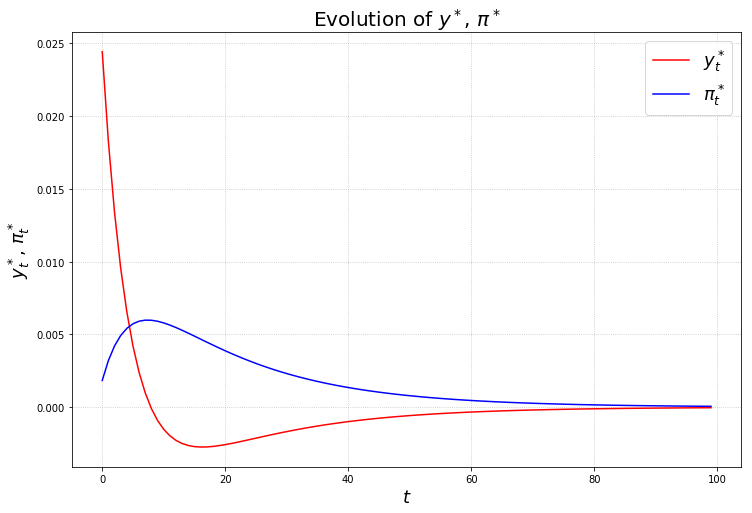

In [24]:
CC = np.zeros(shape = 100)
XX = np.zeros(shape = 100)
XX[0] = 0.1


yy, pipi = run_model(X = XX,
                     C = CC, 
                     y = 0,
                     pi = 0,
                     s = 0,
                     v = 0,
                     n_steps = 100)


problem_two.plot_single_shock(yy, pipi)
plt.show()

<br>
<br>

## Answer to question 4

>**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:
>
>1. Variance of $y_t$, $var(y_t)$
>2. Variance of $\pi_t$, $var(\pi_t)$
>3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
>4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
>5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

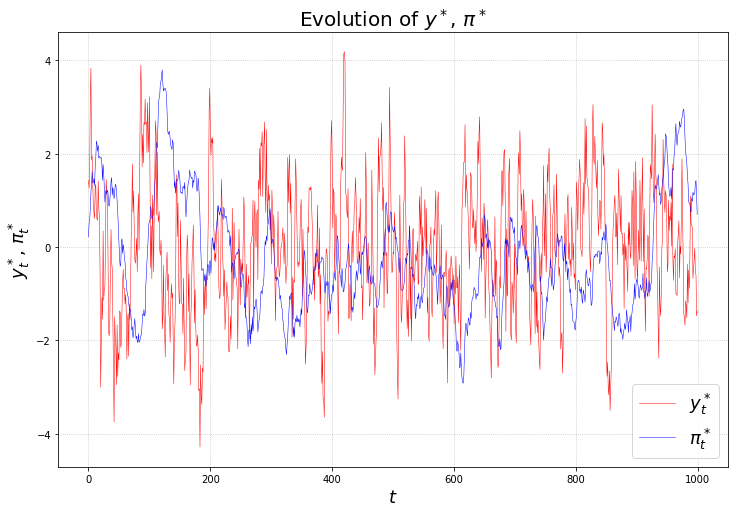

In [25]:
np.random.seed(0)
XX = np.random.normal(0, par['sigma_x'], size = 1000)
CC = np.random.normal(0, par['sigma_c'], size = 1000)

yy2, pipi2 = run_model(X = XX,
                     C = CC, 
                     y = 0,
                     pi = 0,
                     s = 0,
                     v = 0,
                     n_steps = 1000)


problem_two.plot_random_shocks(yy2, pipi2)
plt.show()

Finally to calculate the statistics asked for: 

In [26]:
def calculate_statistics(y_vec, pi_vec):
    y_var = y_vec.var()
    pi_var = pi_vec.var()
    y_pi_corr = np.corrcoef(y_vec, pi_vec)[0,1]
    autocorr_y = np.corrcoef(y_vec[1:], y_vec[:-1])[0,1]
    autocorr_pi = np.corrcoef(pi_vec[1:], pi_vec[:-1])[0,1]
    
    return y_var, pi_var, y_pi_corr, autocorr_y, autocorr_pi


yv, piv, ypic, acy, acpi = calculate_statistics(yy2, pipi2)

print("""
Variance of y: {yvar}
Variance of pi: {pivar}
Correlation of y and pi: {ypicorr}
autocorrelation of y: {autocorry}
autocorrelation of pi: {autocorrpi}
""".format(yvar = yv,
          pivar = piv,
          ypicorr = ypic,
          autocorry = acy,
          autocorrpi = acpi
          )
     )



Variance of y: 1.8361662180922218
Variance of pi: 1.4289631278172137
Correlation of y and pi: -0.1433644642705664
autocorrelation of y: 0.7690099792210964
autocorrelation of pi: 0.9849139427261434



<br>
<br>

## Answer to question 5

> **Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

First we show the curve of $corr(y^*_t, \pi^*_t)$ for varying $\phi$:

In [27]:
def stats_vary_phi_sigma(phi, sigma_x = par['sigma_x'], sigma_c = par['sigma_c']):
    '''
    '''
    np.random.seed(0)
    XX = np.random.normal(0, sigma_x, size = 1000)
    CC = np.random.normal(0, sigma_c, size = 1000)

    y_vec, pi_vec = run_model(X = XX,
                         C = CC, 
                         y = 0,
                         pi = 0,
                         s = 0,
                         v = 0,
                         phi = phi,
                         n_steps = 1000)
    
    var_y, var_pi, corr_y_pi, auto_y, auto_pi = calculate_statistics(y_vec, pi_vec)
    
    return var_y, var_pi, corr_y_pi, auto_y, auto_pi


def corr_vary_phi(phi):
    return stats_vary_phi_sigma(phi)[2]


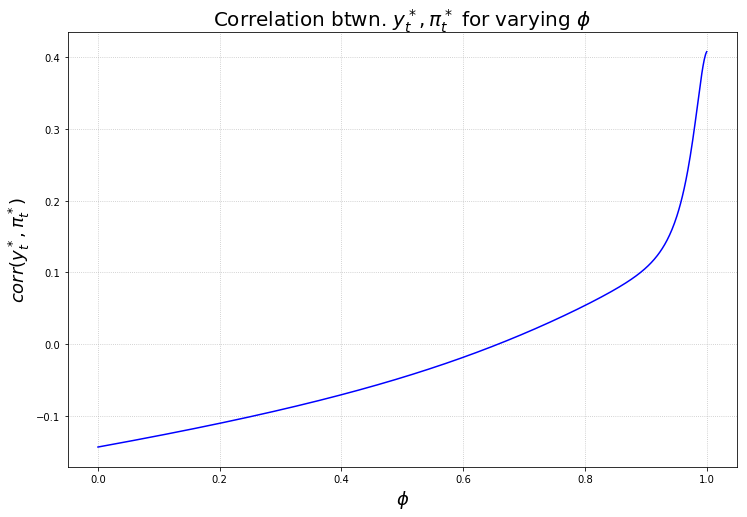

In [28]:
phi_space = np.linspace(0,1, 1000)
corrout = [corr_vary_phi(p) for p in phi_space]

problem_two.plot_correlation_and_phi(phi_space, corrout)
plt.show()

Now to identify the level of $\phi$ that results in a correlation of approximately 0.31 we define a target function of the curve plotted above minus the targed of 0.31. When this function is 0 we know we have the correct value of $\phi$, $\phi^*=0.98$.

In [29]:
def phi_target(phi):
    corr = corr_vary_phi(phi)
    return corr - 0.31

res = optimize.root_scalar(phi_target,bracket=[0,1],method='brentq')
res

      converged: True
           flag: 'converged'
 function_calls: 10
     iterations: 9
           root: 0.9812247943453689

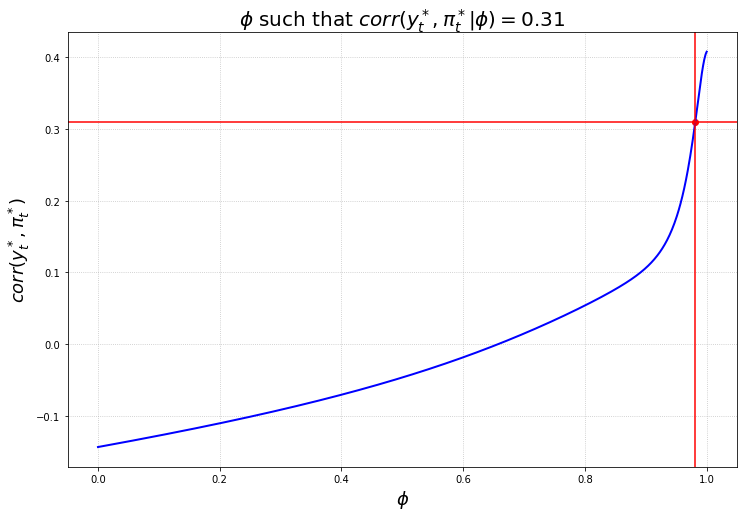

In [30]:
def plot_correlation_and_phi_target(phi_space, correlation, root):
    ''' Plot the found phi^*
    '''
    phi_star = corr_vary_phi(root)
    
    fig, ax = plt.subplots(figsize = (12,8))
    ax.plot(phi_space, correlation, color = 'blue', linewidth = 2)

    ax.scatter([root], [phi_star], color = 'red')
    ax.axvline([root], color = 'red')
    ax.axhline([phi_star], color = 'red')
    ax.grid(which='major', alpha=0.8, linestyle='dotted')
    ax.set_xlabel('$\phi$', fontsize = 18)
    ax.set_ylabel('$corr(y^*_t, \pi^*_t)$', fontsize = 18)
    ax.set_title("$\phi$ such that $corr(y_t^*, \pi_t^*|\phi)=0.31$", fontsize = 20)
    
    return fig

plot_correlation_and_phi_target(phi_space, corrout, res.root)
plt.show()

<br>
<br>

## Answer to question 6

> **Question 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:
>
>1. $var(y_t) = 1.64$
>2. $var(\pi_t) = 0.21$
>3. $corr(y_t,\pi_t) = 0.31$
>4. $corr(y_t,y_{t-1}) = 0.84$
>5. $corr(\pi_t,\pi_{t-1}) = 0.48$

To use the optimizer we set up an initial guess `x0` wichi simply contains the parameter values supplied in the problem text. We then define a target function which stores all of the target variables and returns the sum of squared deviations from the sought parameter values.

In [31]:
x0 = np.array([par['phi'], par['sigma_x'], par['sigma_c']])

def target_phi_sigma(o):
    var_y, var_pi, corr_y_pi, auto_y, auto_pi = stats_vary_phi_sigma(o[0], o[1], o[2])

    res = np.zeros(shape = 5)    
    res[0] = var_y - 1.64
    res[1] = var_pi - 0.21
    res[2] = corr_y_pi - 0.31
    res[3] = auto_y - 0.84
    res[4] = auto_pi - 0.48
    
    return sum(res**2)
 
bounds = ((0,1), (0,None), (0,None))

We use SLSQP to optimize the target function and report calibrated parameters and the resulting statistics from the target for each of the five statistics. The optimizer is quite far from the target on $var(\pi)$ but gets reasonably close for the other statistics.

In [32]:
result = optimize.minimize(target_phi_sigma,
                           x0,
                           method='SLSQP',
                           bounds=bounds,
                           options={'disp':True})

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.02650972098660021
            Iterations: 12
            Function evaluations: 70
            Gradient evaluations: 12


In [33]:
print("""
Identified parameters:
phi: {p}
sigma_x: {sx}
sigma_c: {sc}
""".format(p=result.x[0], sx = result.x[1], sc = result.x[2]))


Identified parameters:
phi: 0.9801410205314028
sigma_x: 3.1037749809074673
sigma_c: 0.1895297980116128



In [34]:
pdev = stats_vary_phi_sigma(result.x[0], result.x[1], result.x[2])
print("""
Calculated statistics:
var(y): {vary}
var(pi): {varpi}
corr(y,pi): {corr}
autocorr(y): {acy}
autocorr(pi): {acp}
""".format(vary = pdev[0], 
           varpi = pdev[1],
           corr = pdev[2],
           acy = pdev[3],
           acp = pdev[4])
     )


Calculated statistics:
var(y): 1.6452384388857575
var(pi): 0.0544646406046203
corr(y,pi): 0.2812101229341539
autocorr(y): 0.8018804815316708
autocorr(pi): 0.4830128081031909



Finally we plot simulated data for the estimated parameter values

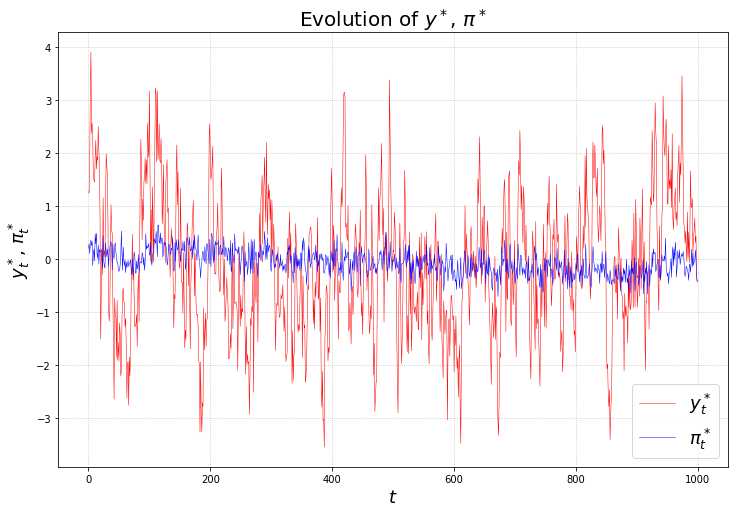

In [35]:
np.random.seed(0)
XX = np.random.normal(0, result.x[1] , size = 1000)
CC = np.random.normal(0, result.x[2], size = 1000)

yy2, pipi2 = run_model(X = XX,
                     C = CC, 
                     y = 0,
                     pi = 0,
                     s = 0,
                     v = 0,
                     phi = result.x[0],
                     n_steps = 1000)


problem_two.plot_random_shocks(yy2, pipi2)
plt.show()

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [36]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

<br>
<br>

## Answer to question 1
> **Question 1:** Plot the histograms of the budget shares for each good across agents.


In [37]:
from examproject import problem_three

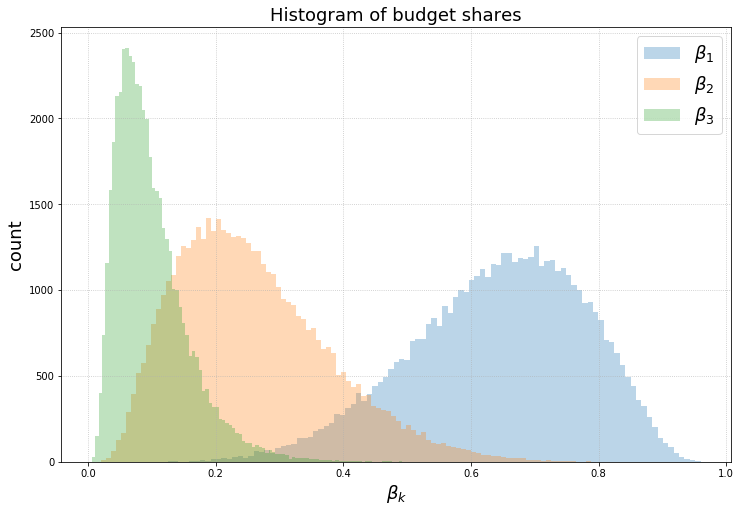

In [38]:
problem_three.plot_histogram(betas)
plt.show()

<br>
<br>

## Answer to question 2
> **Question 2:** Plot the excess demand functions.

In [39]:
def income(p, e):
    e1, e2, e3 = e[0], e[1], e[2]    
    p1, p2, p3 = p[0], p[1], p[2]
    
    return p1*e1 + p2*e2 + p3*e3


def x_star_i_j(p, e, betas):
    I = income(p, e)
    p1, p2, p3 = p[0], p[1], p[2]
    
    Ip = np.array([I/p1, I/p2, I/p3]).T
    
    return np.multiply(betas, Ip)


def excess_demand_i_j(p, e, betas):
    x_s_i_j = x_star_i_j(p, e, betas)
    e1, e2, e3 = e[0], e[1], e[2]    
    
    return x_s_i_j - np.array([e1,e2,e3]).T
    

def excess_demand_i(p, e, betas):    
    e_i_j = excess_demand_i_j(p, e, betas)    
    return np.array([np.sum(e_i_j[:,0]), np.sum(e_i_j[:,1]), np.sum(e_i_j[:,2])])

In [40]:
p1 = np.linspace(1,10, 30)
p2 = np.linspace(1,10, 30)

pp1 = list()
pp2 = list()
dd = list()

for p_1 in p1:
    for p_2 in p2:
        val = excess_demand_i([p_1,p_2,1], [e1,e2,e3], betas)
        pp1.append(p_1)
        pp2.append(p_2)
        dd.append(val)
        
        
pp1 = np.array(pp1)
pp2 = np.array(pp2)

dd1 = np.array([v[0] for v in dd])
dd2 = np.array([v[1] for v in dd])
dd3 = np.array([v[2] for v in dd])

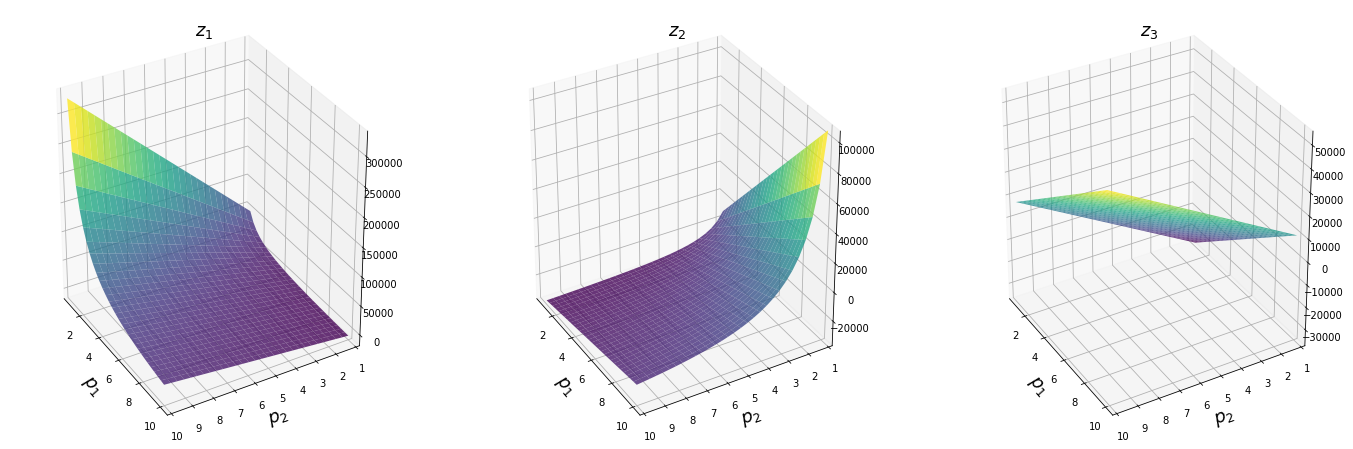

In [41]:
problem_three.plot_excess_demand(pp1,pp2, dd1, dd2,dd3)
plt.show()

<br>
<br>

## Answer to question 3
>**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:
>
>1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
>2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
>3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
>4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [42]:

def solver(p1, p2, e, eps, kappa, max_iter = 100):
    assert p1 > 0
    assert p2 > 0 
    assert eps > 0
    e1,e2,e3 = e
    
    for _ in range(max_iter):
        
        z1, z2, _ = list(excess_demand_i([p1,p2,1], [e1,e2,e3], betas))
    
        if abs(z1) < eps and abs(z2) < eps:
            print("Convergence")
            return (p1,p2), (z1,z2), True
    
        p1 += kappa*(z1/N)
        p2 += kappa*(z2/N)
    
    print("No convergence")
    return (p1,p2), (z1,z2), False
    

def report(solverout):
    p, z, status = solverout
    
    if status == True:
        convs = "Converged"
    else:
        convs = "Not converged"
    
    z3 = excess_demand_i([p[0], p[1], 1], [e1,e2,e3], betas)[2]
    
    print("""
    Solver status: {conv}
    
    Found prices
    p1: {p1}
    p2: {p2}
    p3: 1
    Excess demands:
    z1: {z1}
    z2: {z2}
    z3: {z3}
    """.format(
        conv = convs,
        p1 = p[0],
        p2 = p[1],
        z1 = z[0],
        z2 = z[1],
        z3 = z3
    ))

In [43]:
result = solver(p1 = .2, p2 = .2, e = [e1,e2,e3], eps = .0001, kappa = .5, max_iter = 5000)
report(result)

Convergence

    Solver status: Converged
    
    Found prices
    p1: 6.490055036326878
    p2: 2.6166939597584244
    p3: 1
    Excess demands:
    z1: 9.965310311343956e-05
    z2: 3.71763535653713e-05
    z3: -0.0007440332640911151
    


<br>
<br>

## Answer to question 4
> **Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

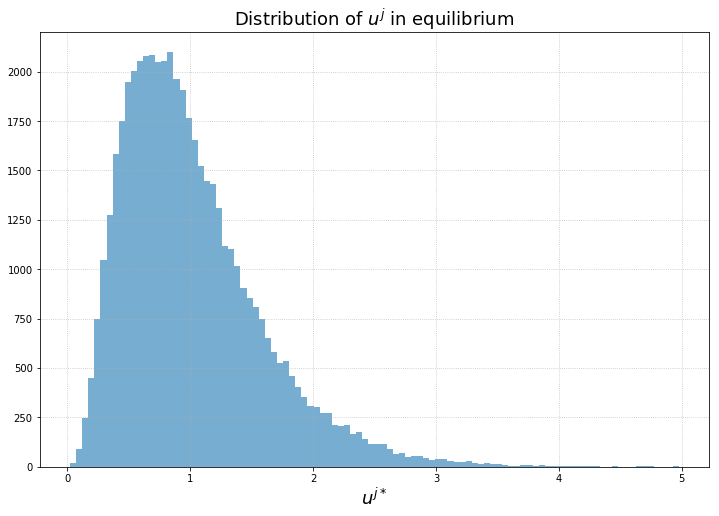

In [44]:
def u(p, e, betas, gamma = gamma):
    ''' Calculate u. We actually calculate e^log(u)
        because this makes matrix algebra a bit 
        easier. 
    '''
    log_x_stars = np.log(x_star_i_j(p, e, betas))
    b_log_x = betas* log_x_stars    
    u = np.exp(gamma*np.sum(b_log_x, axis = 1))
    return u


p, z, status = result
utilities = u([p[0], p[1], 1], [e1,e2,e3], betas)

problem_three.plot_utility_distribution(utilities)
plt.show()

In [45]:
print(f"""
Statistics of utility distribution:
Mean: {np.mean(utilities)}
Var: {np.var(utilities)}
""")


Statistics of utility distribution:
Mean: 1.010164459952614
Var: 0.3173402041056455



<br>
<br>

## Answer to question 5
>**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [46]:
e1_uni = np.ones(shape=N)
e2_uni = np.ones(shape=N)
e3_uni = np.ones(shape=N)

Convergence

    Solver status: Converged
    
    Found prices
    p1: 6.4473265425519175
    p2: 2.590820325837617
    p3: 1
    Excess demands:
    z1: 9.961341202036067e-05
    z2: 3.7039414751305344e-05
    z3: -340.38999554363414
    


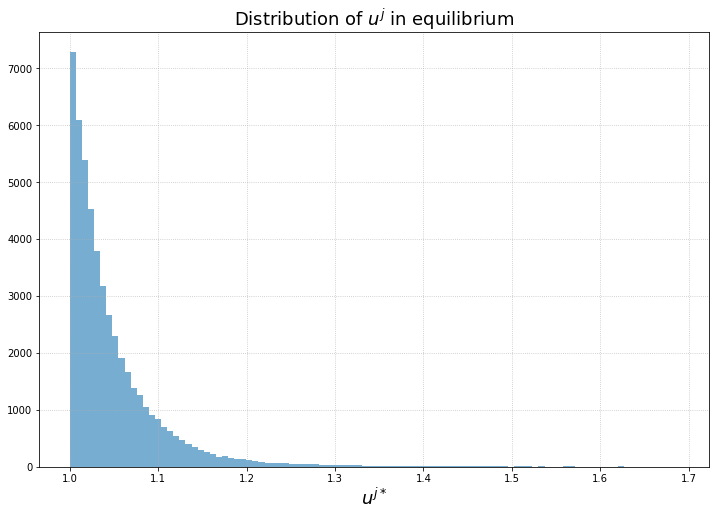

In [47]:
result2 = solver(p1 = .2, p2 = .2, e = [e1_uni,e2_uni,e3_uni], eps = .0001, kappa = .5, max_iter = 5000)
report(result2)


p, z, status = result2
utilities2 = u([p[0], p[1], 1], [e1_uni,e2_uni,e3_uni], betas)



problem_three.plot_utility_distribution(utilities2)
plt.show()

In [48]:
print(f"""
Statistics of utility distribution:
Mean: {np.mean(utilities2)}
Var: {np.var(utilities2)}
""")


Statistics of utility distribution:
Mean: 1.0480246185936566
Var: 0.0030358024565910195



In [49]:
g_space = np.linspace(0, 5, 100)
mean_util_of_g = list()
var_util_of_g = list()

for g in g_space:
    util = u([p[0], p[1], 1], [e1_uni,e2_uni,e3_uni], betas, gamma = g)
    
    mean_util_of_g.append(np.mean(util))
    var_util_of_g.append(np.var(util))

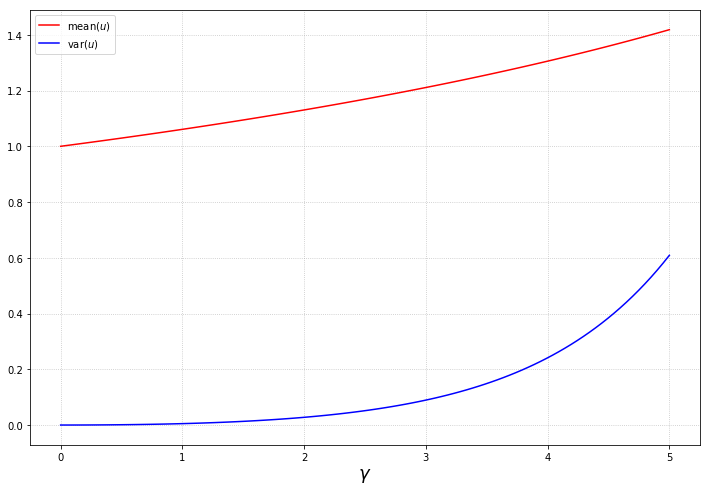

In [50]:
problem_three.plot_mean_variance(g_space, mean_util_of_g, var_util_of_g)
plt.show()